# VolumeCollection - Working with Volume Groups

A VolumeCollection organizes Volumes with consistent X/Y/Z dimensions. This notebook covers:

- Collection properties and volume-level metadata (`obs`)
- Volume indexing (same patterns as [01_radi_object](./01_radi_object.ipynb#subject-indexing))
- Batch operations and visualization
- Collection Query API

**Prerequisites:** Run [00_ingest_brats.ipynb](./00_ingest_brats.ipynb) first.

In [1]:
import sys

sys.path.insert(0, "..")


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from config import BRATS_URI, S3_REGION

from radiobject.ctx import (
    CompressionConfig,
    Compressor,
    S3Config,
    SliceOrientation,
    TileConfig,
    configure,
)
from radiobject.radi_object import RadiObject

print(f"RadiObject URI: {BRATS_URI}")

RadiObject URI: s3://souzy-scratch/radiobject/brats-tutorial


In [2]:
# Configure S3 if using S3 URI
if BRATS_URI.startswith("s3://"):
    configure(s3=S3Config(region=S3_REGION))

configure(
    tile=TileConfig(orientation=SliceOrientation.AXIAL),
    compression=CompressionConfig(algorithm=Compressor.ZSTD, level=3),
)

In [3]:
radi = RadiObject(BRATS_URI)
radi

RadiObject(5 subjects, 4 collections: [T2w, T1gd, T1w, FLAIR])

In [4]:
# Access via attribute or method
flair = radi.FLAIR
t1w = radi.collection("T1w")

# Display the collection
flair

VolumeCollection(5 volumes, shape=240x240x155)

In [5]:
print(f"Shape (X, Y, Z): {flair.shape}")
print(f"Number of volumes: {len(flair)}")
print(f"Volume IDs: {flair.obs_ids}")

Shape (X, Y, Z): (240, 240, 155)
Number of volumes: 5


Volume IDs: ['BRATS_001_FLAIR', 'BRATS_002_FLAIR', 'BRATS_003_FLAIR', 'BRATS_004_FLAIR', 'BRATS_005_FLAIR']


In [6]:
# Read all volume metadata
flair.obs.read()

,obs_subject_id,obs_id,series_type,voxel_spacing,dimensions,datatype,bitpix,scl_slope,scl_inter,xyzt_units,spatial_units,qform_code,sform_code,axcodes,affine_json,orientation_source,source_path
0,BRATS_001,BRATS_001_FLAIR,FLAIR,"(1.0, 1.0, 1.0)","(240, 240, 155)",16,32,1.0,0.0,0,unknown,0,2,RAS,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",nifti_sform,/var/folders/dj/0_0s64j55hn0gk7rrvj09zf80000gn...
1,BRATS_002,BRATS_002_FLAIR,FLAIR,"(1.0, 1.0, 1.0)","(240, 240, 155)",16,32,1.0,0.0,0,unknown,0,2,RAS,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",nifti_sform,/var/folders/dj/0_0s64j55hn0gk7rrvj09zf80000gn...
2,BRATS_003,BRATS_003_FLAIR,FLAIR,"(1.0, 1.0, 1.0)","(240, 240, 155)",16,32,1.0,0.0,0,unknown,0,2,RAS,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",nifti_sform,/var/folders/dj/0_0s64j55hn0gk7rrvj09zf80000gn...
3,BRATS_004,BRATS_004_FLAIR,FLAIR,"(1.0, 1.0, 1.0)","(240, 240, 155)",16,32,1.0,0.0,0,unknown,0,2,RAS,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",nifti_sform,/var/folders/dj/0_0s64j55hn0gk7rrvj09zf80000gn...
4,BRATS_005,BRATS_005_FLAIR,FLAIR,"(1.0, 1.0, 1.0)","(240, 240, 155)",16,32,1.0,0.0,0,unknown,0,2,RAS,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",nifti_sform,/var/folders/dj/0_0s64j55hn0gk7rrvj09zf80000gn...


In [7]:
# Available columns (includes NIfTI metadata)
print(f"Columns: {flair.obs.columns}")

Columns: ['series_type', 'voxel_spacing', 'dimensions', 'datatype', 'bitpix', 'scl_slope', 'scl_inter', 'xyzt_units', 'spatial_units', 'qform_code', 'sform_code', 'axcodes', 'affine_json', 'orientation_source', 'source_path']


In [8]:
# Filter volume metadata
flair.obs.read(columns=["obs_id", "obs_subject_id", "series_type", "dimensions"])

,obs_subject_id,obs_id,series_type,dimensions
0,BRATS_001,BRATS_001_FLAIR,FLAIR,"(240, 240, 155)"
1,BRATS_002,BRATS_002_FLAIR,FLAIR,"(240, 240, 155)"
2,BRATS_003,BRATS_003_FLAIR,FLAIR,"(240, 240, 155)"
3,BRATS_004,BRATS_004_FLAIR,FLAIR,"(240, 240, 155)"
4,BRATS_005,BRATS_005_FLAIR,FLAIR,"(240, 240, 155)"


## Volume Indexing

Same patterns as RadiObject: `iloc`, `loc`, `[]`, boolean masks.

In [ ]:
# iloc (by position), loc (by obs_id), bracket (shorthand)
print(f"iloc[0]:   {flair.iloc[0]}")
print(f"iloc[0:3]: {len(flair.iloc[0:3])} volumes")
print(f"loc['{flair.obs_ids[0]}']: {flair.loc[flair.obs_ids[0]]}")
print(f"flair[0]:  {flair[0].obs_id}")

# Boolean mask indexing
mask = np.array([True, False, True, False, True])
print(f"\nBoolean mask: {[v.obs_id for v in flair.iloc[mask]]}")

In [13]:
# Compute statistics across all volumes using direct iteration
stats = []
for vol in flair:  # Direct iteration over collection
    data = vol.to_numpy()
    stats.append(
        {
            "obs_id": vol.obs_id,
            "mean": data.mean(),
            "std": data.std(),
            "max": data.max(),
        }
    )

pd.DataFrame(stats)

,obs_id,mean,std,max
0,BRATS_001_FLAIR,86.020485,210.889191,1829.0
1,BRATS_002_FLAIR,101.829483,240.737076,1905.0
2,BRATS_003_FLAIR,97.251244,222.069824,1871.0
3,BRATS_004_FLAIR,80.306801,211.583481,1809.0
4,BRATS_005_FLAIR,110.799026,267.032806,2365.0


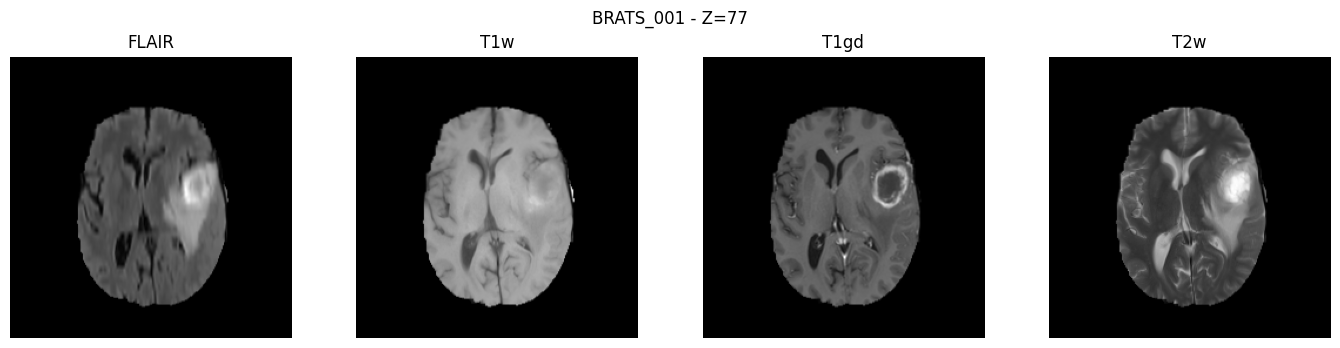

In [14]:
# Compare modalities for one subject
subject_ids = radi.obs_subject_ids
subject_id = subject_ids[0]
z_slice = 77
modalities = ["FLAIR", "T1w", "T1gd", "T2w"]

fig, axes = plt.subplots(1, 4, figsize=(14, 3.5))
for i, mod in enumerate(modalities):
    vol = radi.collection(mod).loc[f"{subject_id}_{mod}"]
    axes[i].imshow(vol.axial(z_slice).T, cmap="gray", origin="lower")
    axes[i].set_title(mod)
    axes[i].axis("off")

plt.suptitle(f"{subject_id} - Z={z_slice}")
plt.tight_layout()
plt.show()

In [15]:
# Convert between obs_id and index using the index property
second_obs_id = flair.obs_ids[1]
idx = flair.index.get_index(second_obs_id)
obs_id = flair.index.get_key(2)

print(f"'{second_obs_id}' -> index {idx}")
print(f"index 2 -> '{obs_id}'")

'BRATS_002_FLAIR' -> index 1
index 2 -> 'BRATS_003_FLAIR'


In [16]:
# Get full obs row for a volume
flair.get_obs_row_by_obs_id(flair.obs_ids[0])

,obs_subject_id,obs_id,series_type,voxel_spacing,dimensions,datatype,bitpix,scl_slope,scl_inter,xyzt_units,spatial_units,qform_code,sform_code,axcodes,affine_json,orientation_source,source_path
0,BRATS_001,BRATS_001_FLAIR,FLAIR,"(1.0, 1.0, 1.0)","(240, 240, 155)",16,32,1.0,0.0,0,unknown,0,2,RAS,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",nifti_sform,/var/folders/dj/0_0s64j55hn0gk7rrvj09zf80000gn...


## Collection Query API

Lazy `query()` for pipeline mode - mirrors RadiObject.query().

In [ ]:
# query() returns lazy CollectionQuery
cq = flair.query().head(3)
print(f"Query: {cq}, count: {cq.count()}")

# Materialize to numpy stack (N, X, Y, Z)
stack = cq.to_numpy_stack()
print(f"Stacked shape: {stack.shape}")

In [23]:
# Example: Creating a standalone collection from NIfTIs
# (Requires raw NIfTI files - see 00_ingest_brats.ipynb for ingestion)

print("""To create a standalone VolumeCollection:

from radiobject.volume_collection import VolumeCollection

# List of (nifti_path, subject_id) tuples
nifti_list = [
    (Path("subject1_FLAIR.nii.gz"), "subject1"),
    (Path("subject2_FLAIR.nii.gz"), "subject2"),
]

collection = VolumeCollection.from_niftis(
    uri="./my_collection",
    niftis=nifti_list,
)
""")

To create a standalone VolumeCollection:

from radiobject.volume_collection import VolumeCollection

# List of (nifti_path, subject_id) tuples
nifti_list = [
    (Path("subject1_FLAIR.nii.gz"), "subject1"),
    (Path("subject2_FLAIR.nii.gz"), "subject2"),
]

collection = VolumeCollection.from_niftis(
    uri="./my_collection",
    niftis=nifti_list,
)



In [24]:
flair.validate()
print("Collection validation passed")

Collection validation passed


## Next Steps

- [03_volume.ipynb](./03_volume.ipynb) - Single volume operations and partial reads
- [04_storage_configuration.ipynb](./04_storage_configuration.ipynb) - Tile orientation, compression, S3